In [3]:
from pathlib import Path
import tarfile
import pandas as pd 
import urllib.request

In [4]:
def load_titanic_data():
    tarball_path = Path("data/titanic.tgz")
    if not tarball_path.is_file():
        Path("data").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="data")
    return [pd.read_csv(Path("data/titanic")/ filename) for filename in ("train.csv", "test.csv")]


In [5]:
train_data, test_data = load_titanic_data()

In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")


In [8]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [10]:
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [12]:
train_data["Pclass"].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [13]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [14]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [59]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]

test_data["AgeBucket"] = test_data["Age"] // 15 * 15
test_data["RelativesOnboard"] = test_data["SibSp"] + test_data["Parch"]

In [60]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Survived          891 non-null    int64  
 1   Pclass            891 non-null    int64  
 2   Name              891 non-null    object 
 3   Sex               891 non-null    object 
 4   Age               714 non-null    float64
 5   SibSp             891 non-null    int64  
 6   Parch             891 non-null    int64  
 7   Ticket            891 non-null    object 
 8   Fare              891 non-null    float64
 9   Cabin             204 non-null    object 
 10  Embarked          889 non-null    object 
 11  AgeBucket         714 non-null    float64
 12  RelativesOnboard  891 non-null    int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 97.5+ KB


In [61]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
])

cat_pipeline = Pipeline([
    ("ordinal_encoder", OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("cat_encoder", OneHotEncoder(sparse_output=False)),
])

In [62]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare", "AgeBucket", "RelativesOnboard"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocessing_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [63]:
x_train = preprocessing_pipeline.fit_transform(train_data)

In [64]:
x_train_df = pd.DataFrame(x_train, columns=preprocessing_pipeline.get_feature_names_out(), index=train_data.index)
x_train_df.head(2)

,num__Age,num__SibSp,num__Parch,num__Fare,num__AgeBucket,num__RelativesOnboard,cat__Pclass_0.0,cat__Pclass_1.0,cat__Pclass_2.0,cat__Sex_0.0,cat__Sex_1.0,cat__Embarked_0.0,cat__Embarked_1.0,cat__Embarked_2.0
PassengerId,,,,,,,,,,,,,,
1,-0.565736,0.432793,-0.473674,-0.502445,-0.493366,0.05916,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.663861,0.432793,-0.473674,0.786845,0.622343,0.05916,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [65]:
y_train = train_data["Survived"].copy()

In [66]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100 ,random_state=42)
forest_clf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [67]:
x_test = preprocessing_pipeline.transform(test_data)
y_pred = forest_clf.predict(x_test)

In [68]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, x_train, y_train, cv=10)
forest_scores.mean()

0.8014481897627965

In [88]:
from sklearn.svm import SVC
import numpy as np 

svc_clf = SVC(gamma='auto')
svc_scores = cross_val_score(svc_clf, x_train, y_train, cv=10)
svc_clf.fit(x_train, y_train)
pred = svc_clf.predict(x_test)
#np.savetxt("data/titanic/titanic_best_pred.csv", pred, delimiter=",")
svc_scores.mean()

# train_data, test_data = load_titanic_data()
# submission = pd.DataFrame({'PassengerId': test_data['PassengerId'],'Survived':pred})
# submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [91]:
submission.to_csv("data/titanic/titanic_best_pred.csv", index=False)

In [74]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}]

svc_clf = SVC(gamma='auto')
grid_search = GridSearchCV(svc_clf, param_grid, cv=10)
grid_search.fit(x_train, y_train)
grid_search.best_score_

0.8294257178526842

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [5, 6, 7,8]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [5, 6, 7, 8],
                          'weights': ['uniform', 'distance']}])

In [71]:
grid_search.best_params_

{'n_neighbors': 6, 'weights': 'uniform'}

In [72]:
grid_search.best_score_

0.807016229712859

In [73]:
param_grid = [{'n_estimators': [100, 150, 200, 250]}]

forest_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(forest_clf, param_grid, cv=10)
grid_search.fit(x_train, y_train)
grid_search.best_score_

0.8014481897627965

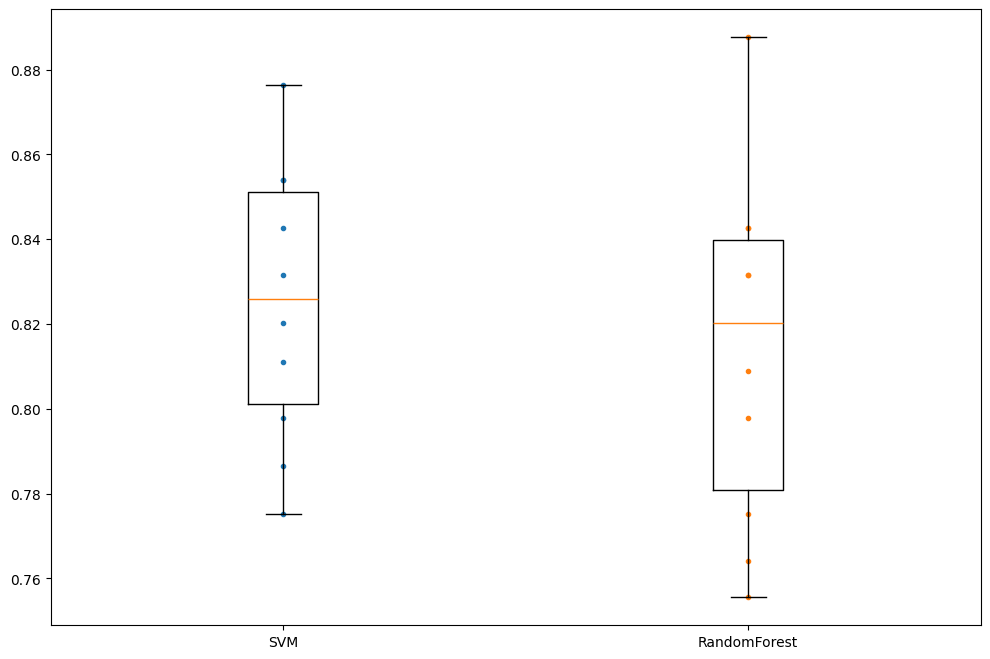

In [36]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(12,8))
plt.plot([1]*10, svc_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svc_scores, forest_scores], labels=("SVM", "RandomForest"))
plt.show()
